# 3 levels opsine model

This script implements a simple 2 level model.
The model is described in the following figure:

<img src="imgs/3levels_model.svg" width="30%">

Red arrows mean photo-influenced transitions

The transition OD, from the Open to the Deactivated state, is considered to be influenced by light.

No transition is admitted from C to O or from O to C. This choice simplyfies the model and it is justified by the very long time required for current recovery (experimentally ~30s).

In [3]:
from matplotlib.pyplot import *
from scipy import *
from scipy.integrate import odeint

import sys
sys.path.append('../scripts')
# from marco_tools.parseDatafile import *
# ion()  # for interactive plotting

%matplotlib inline 

global C,O,D,K_off,K_on,pulse_end,pulse_start,N,tau,v,alpha
global powervalues,pulse_end_times,dt
global datalength
global pulse_end_times,lightpower

### chose number of experimental data:
the experiment number

In [4]:
n_data = 8

### set Parameters for DATA fit
All transition constant are written as a function of the so called "tau off": $$\tau_{OFF}$$

It is the characteristic decay time of the current when the light pulse turns OFF.

In the following, it will be associated with K_off[O,C]

In [5]:
    tau = 25 #17.9 # usually called "tauoff" [ms] Exp Physiol. 2011 Jan; 96(1): 19–25. 
    k = 1.0/tau

In [4]:
def setParametersForDataFit():
    """
    set the K parameters
    These parameters are good for fitting Rossella's data
    """
    global C,O,D,K_off,K_on,pulse_end,pulse_start,N,tau,v,alpha, k

    N = 275
    
    pulse_start = 116 # starting time of light pulse in ms
    pulse_end = pulse_end_times[n_data] # ending time of light pulse in ms
    
    # CONSTANTS DEFINING THE STATES
    C = 0   # Closed state
    O = 1   # Opens state
    D = 2   # Desensitized state
    
    # TRANSITION RATES
    K_off = zeros([3,3])# transition coefficient MATRIX when light is OFF
    K_on =  zeros([3,3])# transition coefficient MATRIX when light is ON

    alpha = 450# fit parameter
    beta = 1/0.00160771704180064# fit parameter
    
    K_off[O,C] = k
    K_on[O,C] = K_off[O,C] # this transition does not depend on light
    
    K_off[C,O] = 0
    K_on[C,O] = k*lightpower*alpha

    K_off[O,D] = k/150*40
    K_on[O,D] = k/(150)*(lightpower*beta+40)

    K_off[D,O] = k/30
    K_on[D,O] = K_off[D,O] # k/30

### Population Dynamics

In [5]:
def three_states_with_light(n,t):
    """
    LDO system for the population dynamics
    """
    # just renameing for easier reading
    Nc = n[0]
    No = n[1]
    Nd = n[2]
    
    if t < pulse_start:
        K = zeros([3,3])
    elif t < pulse_end:
        K = K_on
    else:
        K = K_off

    
    return [
            -K[C,O]*Nc -K[C,D]*Nc +K[D,C]*Nd +K[O,C]*No, # = Nc'
            -K[O,D]*No -K[O,C]*No +K[C,O]*Nc +K[D,O]*Nd, # = No'
            -K[D,C]*Nd -K[D,O]*Nd +K[O,D]*No +K[C,D]*Nc # =Nd'
            ]

### Set experimental parameters

In [6]:
def experimentalParameters():
    """
    Set the parameters used in the experiment, as Rossella gave them to me.
    """
    global powervalues,pulse_end_times,dt
    dt = 0.1 #acquisition time [ms]
    
    # power values of light pulse (what unit?)
    powervalues = array([
    0.0836012861736334,
    0.0498392282958199,
    0.0249196141479099,
    0.0160771704180064,
    0.0128617363344051,
    0.00803858520900321,
    0.00643086816720257,
    0.00321543408360128,
    0.00160771704180064,
    ])
    powervalues = powervalues[::-1]
    
    # End times for the pulses
    pulse_end_times = array([
    225,215,205,195,185,175,165,155,135
    ])
    dt = 0.1    # ms

### Plot Data

In [7]:
def plotData(n_data):
    """
    plot the chosen data
    """
    global datalength
    experimentalParameters()
    
    # Experimental data
    folder = '../experimental'
    filename = '/cell_100_ChR2.txt'

    data = parseDatafile(folder+filename,'\t')
    datalength = len(data[n_data])

    t = [it*dt for it in range(0,datalength)]
    plot(t,data[n_data],'.')

### Plot Model

In [12]:
def plotModel():
    """
    plot the model
    """
    global pulse_end_times,lightpower
    func =  three_states_with_light
    
    # Kon = Koff*alpha*power20
    lightpower = powervalues[n_data]
    setParametersForDataFit()

    t = [it*dt for it in range(0,datalength)]
    
    yinit = [N,0,0]
    y = odeint(func,yinit,t,hmax=(pulse_end-pulse_start))
    
    #plot(t,y[:,0],t,y[:,1])
    #plot(t,y[:,0],'r',t,y[:,1])
    plot(t,-y[:,1],'r')
    plot(t,[-N*(K_on[C,O]/(K_on[C,O]+K_on[O,C]))]*len(t),'--')
    axis([100,300,-300,20])

NameError: name 'temp_max' is not defined

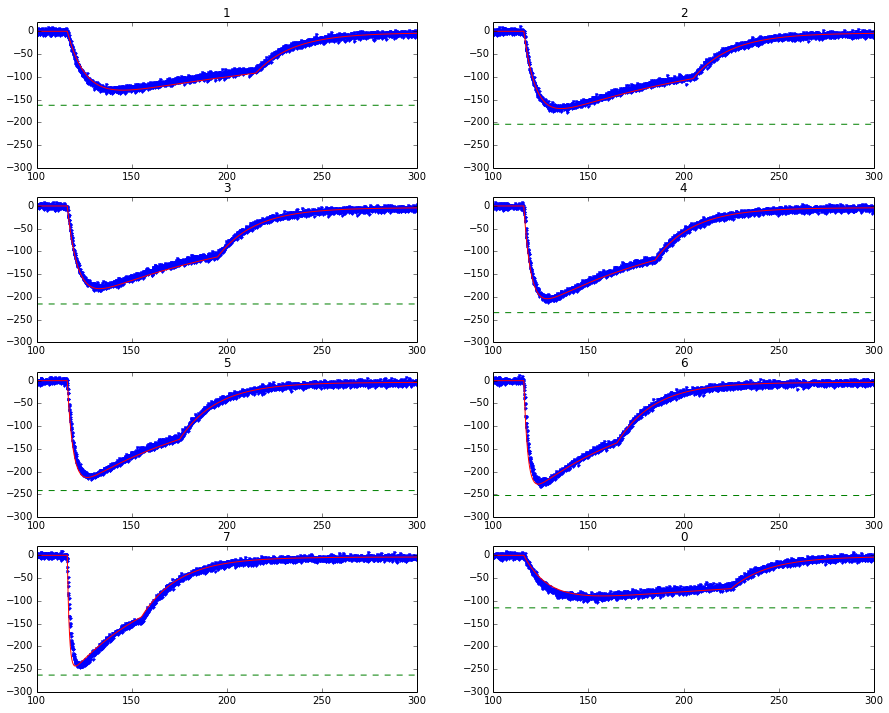

In [9]:
figure(1)
clf()
figure(figsize=(15,12), dpi=150, facecolor='w', edgecolor='k')
for n_data in range(0,8):
    subplot(4,2,n_data)
    title(n_data)
    plotData(n_data)    
    plotModel()
    
show()